In [3]:
# Making versions compatible
!pip uninstall scikit-learn -y -q
!pip install -U scikit-learn==1.3.0 -q
!pip uninstall lightgbm -y -q
!pip install -U lightgbm==3.3.5 -q
!pip uninstall xgboost -y -q
!pip install -U xgboost==2.0.1 -q
!pip install -U kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 71.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.3.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.3 MB/s eta 0:00:00


In [1]:
# Loading other packages
import pandas as pd
import geopandas as gpd
!pip install contextily -q
import contextily as cx
!pip install alibi -q
from alibi.explainers import ALE, plot_ale, PartialDependence, plot_pd, PartialDependenceVariance, plot_pd_variance, PermutationImportance, plot_permutation_importance
!pip install gdown -q
import gdown
import os
import urllib.request
import zipfile
from joblib import load
import plotly.graph_objects as go
from datetime import timedelta
import numpy as np
from scipy.stats import bootstrap
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 31.5 MB/s eta 0:00:00


In [2]:
# Loading station dataset
df_est = pd.read_csv("stations.csv", decimal=",", encoding = "ISO-8859-1")
gdf = gpd.GeoDataFrame(
    df_est, geometry=gpd.points_from_xy(df_est.Longitude, df_est.Latitude), crs="EPSG:4326"
)
gdf = gdf.sort_index(ascending=False).reset_index(drop=True)

df_E = pd.DataFrame({'id' : gdf.index,
                     'codigo' : gdf.Codigo,
                     'nome' : gdf['Nome_Estacao'],
                     'lat' : gdf.geometry.y,
                     'lon' : gdf.geometry.x,
                     'area_drenagem' : round(gdf.Area_Drenagem_km2/1000, 2),
                     'distancia_exultorio' : round(gdf['Distancia_exultorio(m)'].astype('float64')/1000, 1)
                     })
df_E

,id,codigo,nome,lat,lon,area_drenagem,distancia_exultorio
0,0,87450004,CAIS MAUÃ C6,-30.0211,-51.2211,82.40,0.0
1,1,87382000,SÃO LEOPOLDO,-29.7589,-51.1483,3.13,54.2
2,2,87380000,CAMPO BOM,-29.6917,-51.0461,2.90,77.7
3,3,87270000,PASSO MONTENEGRO,-29.7011,-51.4411,4.36,70.4
4,4,87230000,COSTA DO RIO CADEIA - MONTANTE,-29.5906,-51.3136,0.85,99.4
5,5,87170000,BARCA DO CAÃ,-29.5900,-51.3833,3.03,90.7
6,6,87010000,TRIUNFO,-29.9419,-51.6942,68.60,55.6
7,7,86950000,TAQUARI,-29.8069,-51.8758,25.90,90.3
8,8,86895000,PORTO MARIANTE,-29.6922,-51.9700,24.60,111.3
9,9,86881000,BOM RETIRO DO SUL - MONTANTE,-29.6081,-51.9511,23.80,123.7


In [5]:
# Downloading ML models
file_id = "1mBdj4aG41ewxSE26TqRhpAQA7Yvqu97a"
output_file = "Modelos_e_Dados.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

Downloading...
From (original): https://drive.google.com/uc?id=1mBdj4aG41ewxSE26TqRhpAQA7Yvqu97a
From (redirected): https://drive.google.com/uc?id=1mBdj4aG41ewxSE26TqRhpAQA7Yvqu97a&confirm=t&uuid=47bf32f3-75c4-49fa-b76b-aabeafa28e76
To: /content/Modelos_e_Dados.zip
100%|██████████| 415M/415M [00:07<00:00, 53.6MB/s]


'Modelos_e_Dados.zip'

In [6]:
# Unzipping
zip_ref = zipfile.ZipFile("Modelos_e_Dados.zip", 'r')
zip_ref.extractall("MeD")
zip_ref.close()

In [7]:
# List of model names
IA_RS = ['sklearn_TransformedTargetRegressor',
         'sklearn_PLSRegression',
         'sklearn_DummyRegressor',
         'sklearn_BaggingRegressor',
         'sklearn_Lasso',
         'sklearn_ElasticNet',
         'sklearn_KNeighborsRegressor',
         'sklearn_MLPRegressor',
         'sklearn_LinearSVR',
         'sklearn_ExtraTreeRegressor',
         'sklearn_LinearRegression',
         "sklearn_NuSVR",
         'sklearn_XGBRegressor',
         'sklearn_LGBMRegressor',
         'sklearn_GaussianProcessRegressor'
        ]

In [8]:
# Prepare input dataset
root= "MeD/IA-RS-Paper - Novo/"

dados_inp_full = pd.read_csv(root+"Data/input_full_interpolated.csv").set_index("datahora")
dados_inp_full = dados_inp_full[[x for x in dados_inp_full.columns if x not in ['level_0', 'index']]]
dados_inp_full.index = pd.to_datetime(dados_inp_full.index)
dados_inp_full = dados_inp_full.dropna()

In [9]:
# Function to get the ML model

def get_production_model_predict(mdl_name,cc,X,hh):
    idxs = X.index
    mth_v = load(root+"/Case"+str(cc)+"/Models"+str(hh)+"/"+str(mdl_name)+"_"+str(hh)+'_delta.joblib')
    outps = mth_v.predict(X.to_numpy()).flatten()
    df_evals = pd.DataFrame(outps,columns = [mdl_name])
    df_evals.index = [x+ timedelta(hours=hh) for x in idxs]
    return mth_v, df_evals

### Reorganizing the data

In [11]:
# Datasets lead time 1h
df_X1 = pd.read_csv("input1h_interpolated.csv").set_index("datahora")
df_y1 = pd.read_csv("output1h_interpolated.csv", index_col='index').set_index("datahora")

df_rename1 = pd.DataFrame({'original': df_X1.columns})
df_rename1 = df_rename1.join(df_rename1['original'].str.split('_', n=1, expand=True).rename(columns={0:'var', 1:'codigo'}))
df_rename1["codigo"] = df_rename1["codigo"].astype(np.int64)
df_rename1['var2'] = 'L'
df_rename1.loc[df_rename1['var'] == 'acum12h','var2'] = 'R'
df_rename1 = df_rename1.merge(df_E)
df_rename1['novo'] = df_rename1['var2'] + df_rename1['id'].astype(str)
df_X1.columns = df_rename1['novo']

df1 = pd.concat([df_X1, df_y1],axis=1)
df1 = df1.dropna()
X1 = df1.drop(columns = 'out1h').to_numpy()
y1 = df1['out1h'].to_numpy()

In [15]:
# Datasets lead time 6h
df_X6 = pd.read_csv("input6h_interpolated.csv").set_index("datahora")
df_y6 = pd.read_csv("output6h_interpolated.csv", index_col='index').set_index("datahora")

df_rename6 = pd.DataFrame({'original': df_X6.columns})
df_rename6 = df_rename6.join(df_rename6['original'].str.split('_', n=1, expand=True).rename(columns={0:'var', 1:'codigo'}))
df_rename6["codigo"] = df_rename6["codigo"].astype(np.int64)
df_rename6['var2'] = 'L'
df_rename6.loc[df_rename6['var'] == 'acum12h','var2'] = 'R'
df_rename6 = df_rename6.merge(df_E)
df_rename6['novo'] = df_rename6['var2'] + df_rename6['id'].astype(str)
df_X6.columns = df_rename6['novo']

df6 = pd.concat([df_X6, df_y6],axis=1)
df6 = df6.dropna()
X6 = df6.drop(columns = 'out6h').to_numpy()
y6 = df6['out6h'].to_numpy()

In [18]:
# Datasets lead time 12h
df_X12 = pd.read_csv("input12h_interpolated.csv").set_index("datahora")
df_y12 = pd.read_csv("output12h_interpolated.csv", index_col='index').set_index("datahora")

df_rename12 = pd.DataFrame({'original': df_X12.columns})
df_rename12 = df_rename12.join(df_rename12['original'].str.split('_', n=1, expand=True).rename(columns={0:'var', 1:'codigo'}))
df_rename12["codigo"] = df_rename12["codigo"].astype(np.int64)
df_rename12['var2'] = 'L'
df_rename12.loc[df_rename12['var'] == 'acum12h','var2'] = 'R'
df_rename12 = df_rename12.merge(df_E)
df_rename12['novo'] = df_rename12['var2'] + df_rename12['id'].astype(str)
df_X12.columns = df_rename12['novo']

df12 = pd.concat([df_X12, df_y12],axis=1)
df12 = df12.dropna()
X12 = df12.drop(columns = 'out12h').to_numpy()
y12 = df12['out12h'].to_numpy()

In [21]:
# Datasets lead time 24h
df_X24 = pd.read_csv("input24h_interpolated.csv").set_index("datahora")
df_y24 = pd.read_csv("output24h_interpolated.csv", index_col='index').set_index("datahora")

df_rename24 = pd.DataFrame({'original': df_X24.columns})
df_rename24 = df_rename24.join(df_rename24['original'].str.split('_', n=1, expand=True).rename(columns={0:'var', 1:'codigo'}))
df_rename24["codigo"] = df_rename24["codigo"].astype(np.int64)
df_rename24['var2'] = 'L'
df_rename24.loc[df_rename24['var'] == 'acum12h','var2'] = 'R'
df_rename24 = df_rename24.merge(df_E)
df_rename24['novo'] = df_rename24['var2'] + df_rename24['id'].astype(str)
df_X24.columns = df_rename24['novo']

df24 = pd.concat([df_X24, df_y24],axis=1)
df24 = df24.dropna()
X24 = df24.drop(columns = 'out24h').to_numpy()
y24 = df24['out24h'].to_numpy()

### Accumulated Local Effects (ALE)

In [12]:
# ALE top 3 models, lead time 1h
EN_2_1,EN_2_Pred_All_1 = get_production_model_predict('sklearn_ElasticNet',2,dados_inp_full,1)
EN_2_1_ale = ALE(EN_2_1.predict, feature_names=df_X1.columns, target_names=df_y1.columns)
EN_2_1_exp = EN_2_1_ale.explain(X1)

LinearSVR_2_1,LinearSVR_2_Pred_All_1 = get_production_model_predict('sklearn_LinearSVR',2,dados_inp_full,1)
LinearSVR_2_1_ale = ALE(LinearSVR_2_1.predict, feature_names=df_X1.columns, target_names=df_y1.columns)
LinearSVR_2_1_exp = LinearSVR_2_1_ale.explain(X1)

NuSVR_2_1,NuSVR_2_Pred_All_1 = get_production_model_predict('sklearn_NuSVR',2,dados_inp_full,1)
NuSVR_2_1_ale = ALE(NuSVR_2_1.predict, feature_names=df_X1.columns, target_names=df_y1.columns)
NuSVR_2_1_exp = NuSVR_2_1_ale.explain(X1)

slopes_en = np.array([((v[-1]-v[0])/(f[-1]-f[0])).item() for v, f in zip(EN_2_1_exp.ale_values, EN_2_1_exp.feature_values)])
df_slopes_2_1 = pd.DataFrame(slopes_en, index=df_X1.columns, columns=['Elastic Net'])

slopes_linearsvr = np.array([((v[-1]-v[0])/(f[-1]-f[0])).item() for v, f in zip(LinearSVR_2_1_exp.ale_values, LinearSVR_2_1_exp.feature_values)])
df_slopes_2_1['Linear SVR'] = slopes_linearsvr

slopes_nusvr = np.array([((v[-1]-v[0])/(f[-1]-f[0])).item() for v, f in zip(NuSVR_2_1_exp.ale_values, NuSVR_2_1_exp.feature_values)])
df_slopes_2_1['Nu SVR'] = slopes_nusvr

df_slopes_2_1['avg'] = df_slopes_2_1.mean(axis=1)

In [16]:
# ALE top 3 models, lead time 6h
LinearSVR_2_6,LinearSVR_2_Pred_All_6 = get_production_model_predict('sklearn_LinearSVR',2,dados_inp_full,6)
LinearSVR_2_6_ale = ALE(LinearSVR_2_6.predict, feature_names=df_X6.columns, target_names=df_y6.columns)
LinearSVR_2_6_exp = LinearSVR_2_6_ale.explain(X6)

NuSVR_2_6,NuSVR_2_Pred_All_6 = get_production_model_predict('sklearn_NuSVR',2,dados_inp_full,6)
NuSVR_2_6_ale = ALE(NuSVR_2_6.predict, feature_names=df_X6.columns, target_names=df_y6.columns)
NuSVR_2_6_exp = NuSVR_2_6_ale.explain(X6)

LASSO_2_6,LASSO_2_Pred_All_6 = get_production_model_predict('sklearn_Lasso',2,dados_inp_full,6)
LASSO_2_6_ale = ALE(LASSO_2_6.predict, feature_names=df_X6.columns, target_names=df_y6.columns)
LASSO_2_6_exp = LASSO_2_6_ale.explain(X6)

slopes_lsvr = np.array([((v[-1]-v[0])/(f[-1]-f[0])).item() for v, f in zip(LinearSVR_2_6_exp.ale_values, LinearSVR_2_6_exp.feature_values)])
df_slopes_2_6 = pd.DataFrame(slopes_lsvr, index=df_X6.columns, columns=['Linear SVR'])

slopes_nusvr = np.array([((v[-1]-v[0])/(f[-1]-f[0])).item() for v, f in zip(NuSVR_2_6_exp.ale_values, NuSVR_2_6_exp.feature_values)])
df_slopes_2_6['Nu SVR'] = slopes_nusvr

slopes_lasso = np.array([((v[-1]-v[0])/(f[-1]-f[0])).item() for v, f in zip(LASSO_2_6_exp.ale_values, LASSO_2_6_exp.feature_values)])
df_slopes_2_6['LASSO'] = slopes_lsvr

df_slopes_2_6['avg'] = df_slopes_2_6.mean(axis=1)

In [19]:
# ALE top 3 models, lead time 12h
LASSO_2_12,LASSO_2_Pred_All_12 = get_production_model_predict('sklearn_Lasso',2,dados_inp_full,12)
LASSO_2_12_ale = ALE(LASSO_2_12.predict, feature_names=df_X12.columns, target_names=df_y12.columns)
LASSO_2_12_exp = LASSO_2_12_ale.explain(X12)

EN_2_12,EN_2_Pred_All_12 = get_production_model_predict('sklearn_ElasticNet',2,dados_inp_full,12)
EN_2_12_ale = ALE(EN_2_12.predict, feature_names=df_X12.columns, target_names=df_y12.columns)
EN_2_12_exp = EN_2_12_ale.explain(X12)

LSVR_2_12,LSVR_2_Pred_All_12 = get_production_model_predict('sklearn_LinearSVR',2,dados_inp_full,12)
LSVR_2_12_ale = ALE(LSVR_2_12.predict, feature_names=df_X12.columns, target_names=df_y12.columns)
LSVR_2_12_exp = LSVR_2_12_ale.explain(X12)

slopes_lasso = np.array([((v[-1]-v[0])/(f[-1]-f[0])).item() for v, f in zip(LASSO_2_12_exp.ale_values, LASSO_2_12_exp.feature_values)])
df_slopes_2_12= pd.DataFrame(slopes_lasso, index=df_X12.columns, columns=['LASSO'])

slopes_en = np.array([((v[-1]-v[0])/(f[-1]-f[0])).item() for v, f in zip(EN_2_12_exp.ale_values, EN_2_12_exp.feature_values)])
df_slopes_2_12['Elastic Net'] = slopes_en

slopes_lsvr = np.array([((v[-1]-v[0])/(f[-1]-f[0])).item() for v, f in zip(LSVR_2_12_exp.ale_values, LSVR_2_12_exp.feature_values)])
df_slopes_2_12['Linear SVR'] = slopes_lsvr

df_slopes_2_12['avg'] = df_slopes_2_12.mean(axis=1)

In [22]:
# ALE top 3 models, lead time 24h
LASSO_2_24,LASSO_2_Pred_All_24 = get_production_model_predict('sklearn_Lasso',2,dados_inp_full,24)
LASSO_2_24_ale = ALE(LASSO_2_24.predict, feature_names=df_X24.columns, target_names=df_y24.columns)
LASSO_2_24_exp = LASSO_2_24_ale.explain(X24)

MLP_2_24,MLP_2_Pred_All_24 = get_production_model_predict('sklearn_MLPRegressor',2,dados_inp_full,24)
MLP_2_24_ale = ALE(MLP_2_24.predict, feature_names=df_X24.columns, target_names=df_y24.columns)
MLP_2_24_exp = MLP_2_24_ale.explain(X24)

EN_2_24,EN_2_Pred_All_24 = get_production_model_predict('sklearn_ElasticNet',2,dados_inp_full,24)
EN_2_24_ale = ALE(EN_2_24.predict, feature_names=df_X24.columns, target_names=df_y24.columns)
EN_2_24_exp = EN_2_24_ale.explain(X24)

slopes_lasso = np.array([((v[-1]-v[0])/(f[-1]-f[0])).item() for v, f in zip(LASSO_2_24_exp.ale_values, LASSO_2_24_exp.feature_values)])
df_slopes_2_24= pd.DataFrame(slopes_lasso, index=df_X24.columns, columns=['LASSO'])

slopes_mlp = np.array([((v[-1]-v[0])/(f[-1]-f[0])).item() for v, f in zip(MLP_2_24_exp.ale_values, MLP_2_24_exp.feature_values)])
df_slopes_2_24['MLP Regressor'] = slopes_mlp

slopes_en = np.array([((v[-1]-v[0])/(f[-1]-f[0])).item() for v, f in zip(EN_2_24_exp.ale_values, EN_2_24_exp.feature_values)])
df_slopes_2_24['Elastic Net'] = slopes_en

df_slopes_2_24['avg'] = df_slopes_2_24.mean(axis=1)

In [24]:
# Dataframe of average ALE in top 3 models, by lead time
df_avg_nivel_slopes_2 = pd.DataFrame(df_slopes_2_1[df_slopes_2_1.index.str.contains('L')]['avg'].sort_index())
df_avg_nivel_slopes_2.columns = ['1h']

df_avg_nivel_slopes_2['6h'] = df_slopes_2_6[df_slopes_2_6.index.str.contains('L')]['avg'].sort_index()
df_avg_nivel_slopes_2['12h'] = df_slopes_2_12[df_slopes_2_12.index.str.contains('L')]['avg'].sort_index()
df_avg_nivel_slopes_2['24h'] = df_slopes_2_24[df_slopes_2_24.index.str.contains('L')]['avg'].sort_index()

df_avg_acum_slopes_2 = pd.DataFrame(df_slopes_2_1[df_slopes_2_1.index.str.contains('R')]['avg'].sort_index())
df_avg_acum_slopes_2.columns = ['1h']

df_avg_acum_slopes_2['6h'] = df_slopes_2_6[df_slopes_2_6.index.str.contains('R')]['avg'].sort_index()
df_avg_acum_slopes_2['12h'] = df_slopes_2_12[df_slopes_2_12.index.str.contains('R')]['avg'].sort_index()
df_avg_acum_slopes_2['24h'] = df_slopes_2_24[df_slopes_2_24.index.str.contains('R')]['avg'].sort_index()

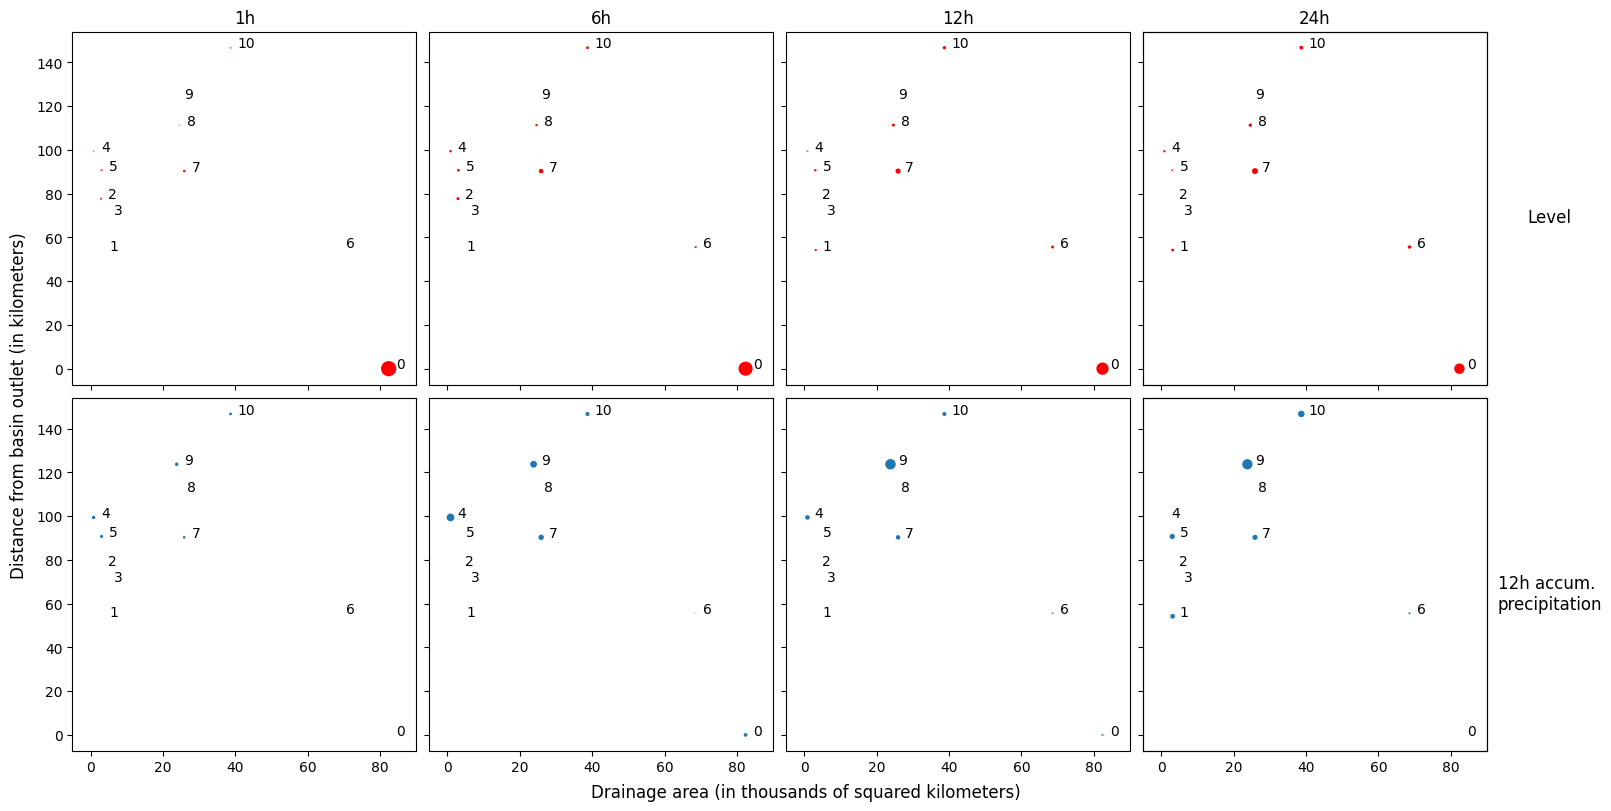

In [28]:
# Plotting ALE
sizes1l = [df_avg_nivel_slopes_2.loc['L0', '1h']*100,
         df_avg_nivel_slopes_2.loc['L1', '1h']*100,
         df_avg_nivel_slopes_2.loc['L2', '1h']*100,
         df_avg_nivel_slopes_2.loc['L3', '1h']*100,
         df_avg_nivel_slopes_2.loc['L4', '1h']*100,
         df_avg_nivel_slopes_2.loc['L5', '1h']*100,
         df_avg_nivel_slopes_2.loc['L6', '1h']*100,
         df_avg_nivel_slopes_2.loc['L7', '1h']*100,
         df_avg_nivel_slopes_2.loc['L8', '1h']*100,
         df_avg_nivel_slopes_2.loc['L9', '1h']*100,
         df_avg_nivel_slopes_2.loc['L10', '1h']*100
        ]
sizes6l = [df_avg_nivel_slopes_2.loc['L0', '6h']*100,
         df_avg_nivel_slopes_2.loc['L1', '6h']*100,
         df_avg_nivel_slopes_2.loc['L2', '6h']*100,
         df_avg_nivel_slopes_2.loc['L3', '6h']*100,
         df_avg_nivel_slopes_2.loc['L4', '6h']*100,
         df_avg_nivel_slopes_2.loc['L5', '6h']*100,
         df_avg_nivel_slopes_2.loc['L6', '6h']*100,
         df_avg_nivel_slopes_2.loc['L7', '6h']*100,
         df_avg_nivel_slopes_2.loc['L8', '6h']*100,
         df_avg_nivel_slopes_2.loc['L9', '6h']*100,
         df_avg_nivel_slopes_2.loc['L10', '6h']*100
        ]
sizes12l = [df_avg_nivel_slopes_2.loc['L0', '12h']*100,
         df_avg_nivel_slopes_2.loc['L1', '12h']*100,
         df_avg_nivel_slopes_2.loc['L2', '12h']*100,
         df_avg_nivel_slopes_2.loc['L3', '12h']*100,
         df_avg_nivel_slopes_2.loc['L4', '12h']*100,
         df_avg_nivel_slopes_2.loc['L5', '12h']*100,
         df_avg_nivel_slopes_2.loc['L6', '12h']*100,
         df_avg_nivel_slopes_2.loc['L7', '12h']*100,
         df_avg_nivel_slopes_2.loc['L8', '12h']*100,
         df_avg_nivel_slopes_2.loc['L9', '12h']*100,
         df_avg_nivel_slopes_2.loc['L10', '12h']*100
        ]
sizes24l = [df_avg_nivel_slopes_2.loc['L0', '24h']*100,
         df_avg_nivel_slopes_2.loc['L1', '24h']*100,
         df_avg_nivel_slopes_2.loc['L2', '24h']*100,
         df_avg_nivel_slopes_2.loc['L3', '24h']*100,
         df_avg_nivel_slopes_2.loc['L4', '24h']*100,
         df_avg_nivel_slopes_2.loc['L5', '24h']*100,
         df_avg_nivel_slopes_2.loc['L6', '24h']*100,
         df_avg_nivel_slopes_2.loc['L7', '24h']*100,
         df_avg_nivel_slopes_2.loc['L8', '24h']*100,
         df_avg_nivel_slopes_2.loc['L9', '24h']*100,
         df_avg_nivel_slopes_2.loc['L10', '24h']*100
        ]

sizes1r = [df_avg_acum_slopes_2.loc['R0', '1h']*100,
         df_avg_acum_slopes_2.loc['R1', '1h']*100,
         df_avg_acum_slopes_2.loc['R2', '1h']*100,
         df_avg_acum_slopes_2.loc['R3', '1h']*100,
         df_avg_acum_slopes_2.loc['R4', '1h']*100,
         df_avg_acum_slopes_2.loc['R5', '1h']*100,
         df_avg_acum_slopes_2.loc['R6', '1h']*100,
         df_avg_acum_slopes_2.loc['R7', '1h']*100,
         df_avg_acum_slopes_2.loc['R8', '1h']*100,
         df_avg_acum_slopes_2.loc['R9', '1h']*100,
         df_avg_acum_slopes_2.loc['R10', '1h']*100
        ]
sizes6r = [df_avg_acum_slopes_2.loc['R0', '6h']*100,
         df_avg_acum_slopes_2.loc['R1', '6h']*100,
         df_avg_acum_slopes_2.loc['R2', '6h']*100,
         df_avg_acum_slopes_2.loc['R3', '6h']*100,
         df_avg_acum_slopes_2.loc['R4', '6h']*100,
         df_avg_acum_slopes_2.loc['R5', '6h']*100,
         df_avg_acum_slopes_2.loc['R6', '6h']*100,
         df_avg_acum_slopes_2.loc['R7', '6h']*100,
         df_avg_acum_slopes_2.loc['R8', '6h']*100,
         df_avg_acum_slopes_2.loc['R9', '6h']*100,
         df_avg_acum_slopes_2.loc['R10', '6h']*100
        ]
sizes12r = [df_avg_acum_slopes_2.loc['R0', '12h']*100,
         df_avg_acum_slopes_2.loc['R1', '12h']*100,
         df_avg_acum_slopes_2.loc['R2', '12h']*100,
         df_avg_acum_slopes_2.loc['R3', '12h']*100,
         df_avg_acum_slopes_2.loc['R4', '12h']*100,
         df_avg_acum_slopes_2.loc['R5', '12h']*100,
         df_avg_acum_slopes_2.loc['R6', '12h']*100,
         df_avg_acum_slopes_2.loc['R7', '12h']*100,
         df_avg_acum_slopes_2.loc['R8', '12h']*100,
         df_avg_acum_slopes_2.loc['R9', '12h']*100,
         df_avg_acum_slopes_2.loc['R10', '12h']*100
        ]
sizes24r = [df_avg_acum_slopes_2.loc['R0', '24h']*100,
         df_avg_acum_slopes_2.loc['R1', '24h']*100,
         df_avg_acum_slopes_2.loc['R2', '24h']*100,
         df_avg_acum_slopes_2.loc['R3', '24h']*100,
         df_avg_acum_slopes_2.loc['R4', '24h']*100,
         df_avg_acum_slopes_2.loc['R5', '24h']*100,
         df_avg_acum_slopes_2.loc['R6', '24h']*100,
         df_avg_acum_slopes_2.loc['R7', '24h']*100,
         df_avg_acum_slopes_2.loc['R8', '24h']*100,
         df_avg_acum_slopes_2.loc['R9', '24h']*100,
         df_avg_acum_slopes_2.loc['R10', '24h']*100
        ]


ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, axes = plt.subplots(2, 4, sharex='all', sharey='all', figsize=(16,8), layout = 'constrained');

axes[0,0].scatter(df_E.area_drenagem, df_E.distancia_exultorio, s=sizes1l, color='red')
axes[0,1].scatter(df_E.area_drenagem, df_E.distancia_exultorio, s=sizes6l, color='red')
axes[0,2].scatter(df_E.area_drenagem, df_E.distancia_exultorio, s=sizes12l, color='red')
axes[0,3].scatter(df_E.area_drenagem, df_E.distancia_exultorio, s=sizes24l, color='red')
axes[1,0].scatter(df_E.area_drenagem, df_E.distancia_exultorio, s=sizes1r)
axes[1,1].scatter(df_E.area_drenagem, df_E.distancia_exultorio, s=sizes6r)
axes[1,2].scatter(df_E.area_drenagem, df_E.distancia_exultorio, s=sizes12r)
axes[1,3].scatter(df_E.area_drenagem, df_E.distancia_exultorio, s=sizes24r)
axes[0,0].set_title("1h")
axes[1,0].set_title(None)
axes[0,1].set_title("6h")
axes[1,1].set_title(None)
axes[0,2].set_title("12h")
axes[1,2].set_title(None)
axes[0,3].set_title("24h")
axes[1,3].set_title(None)
axes[0,0].set_xlim([-5, 90])
axes[0,1].set_xlim([-5, 90])
axes[0,2].set_xlim([-5, 90])
axes[0,3].set_xlim([-5, 90])
axes[1,0].set_xlim([-5, 90])
axes[1,1].set_xlim([-5, 90])
axes[1,2].set_xlim([-5, 90])
axes[1,3].set_xlim([-5, 90])
axes2 = axes[0,3].twinx()
axes2.set_ylabel('Level', rotation=0, fontsize=12, labelpad=45)
axes2.set_yticks([])
axes3 = axes[1,3].twinx()
axes3.set_ylabel('12h accum. \nprecipitation', rotation=0, fontsize=12, labelpad=45)
axes3.set_yticks([])

fig.supylabel('Distance from basin outlet (in kilometers)')
fig.supxlabel('Drainage area (in thousands of squared kilometers)')
for i, txt in enumerate(ids):
    axes[0,0].annotate(txt, (df_E.area_drenagem[i], df_E.distancia_exultorio[i]),
                 xytext=(df_E.area_drenagem[i]+2, df_E.distancia_exultorio[i]),
                 )
    axes[0,1].annotate(txt, (df_E.area_drenagem[i], df_E.distancia_exultorio[i]),
                 xytext=(df_E.area_drenagem[i]+2, df_E.distancia_exultorio[i]),
                 )
    axes[0,2].annotate(txt, (df_E.area_drenagem[i], df_E.distancia_exultorio[i]),
                 xytext=(df_E.area_drenagem[i]+2, df_E.distancia_exultorio[i]),
                 )
    axes[0,3].annotate(txt, (df_E.area_drenagem[i], df_E.distancia_exultorio[i]),
                 xytext=(df_E.area_drenagem[i]+2, df_E.distancia_exultorio[i]),
                 )
    axes[1,0].annotate(txt, (df_E.area_drenagem[i], df_E.distancia_exultorio[i]),
                 xytext=(df_E.area_drenagem[i]+2, df_E.distancia_exultorio[i]),
                 )
    axes[1,1].annotate(txt, (df_E.area_drenagem[i], df_E.distancia_exultorio[i]),
                 xytext=(df_E.area_drenagem[i]+2, df_E.distancia_exultorio[i]),
                 )
    axes[1,2].annotate(txt, (df_E.area_drenagem[i], df_E.distancia_exultorio[i]),
                 xytext=(df_E.area_drenagem[i]+2, df_E.distancia_exultorio[i]),
                 )
    axes[1,3].annotate(txt, (df_E.area_drenagem[i], df_E.distancia_exultorio[i]),
                 xytext=(df_E.area_drenagem[i]+2, df_E.distancia_exultorio[i]),
                 )
plt.show()
fig.savefig('Fig6.png')

### Permutation importance

In [26]:
# Calculating the permutation importance for the top 3 models, by lead time
feature_names = df_X1.columns.to_list()

pfi21 = PermutationImportance(predictor=EN_2_1.predict,
                            #loss_fns='mean_absolute_error',
                            score_fns='r2',
                            feature_names=feature_names)
exp21 = pfi21.explain(X1, y1, kind='difference')

pfi22 = PermutationImportance(predictor=LinearSVR_2_1.predict,
                            #loss_fns='mean_absolute_error',
                            score_fns='r2',
                            feature_names=feature_names)
exp22 = pfi22.explain(X1, y1, kind='difference')

pfi23 = PermutationImportance(predictor=NuSVR_2_1.predict,
                            #loss_fns='mean_absolute_error',
                            score_fns='r2',
                            feature_names=feature_names)
exp23 = pfi23.explain(X1, y1, kind='difference')

pfi24 = PermutationImportance(predictor=LinearSVR_2_6.predict,
                            #loss_fns='mean_absolute_error',
                            score_fns='r2',
                            feature_names=feature_names)
exp24 = pfi24.explain(X6, y6, kind='difference')

pfi25 = PermutationImportance(predictor=NuSVR_2_6.predict,
                            #loss_fns='mean_absolute_error',
                            score_fns='r2',
                            feature_names=feature_names)
exp25 = pfi25.explain(X6, y6, kind='difference')

pfi26 = PermutationImportance(predictor=LASSO_2_6.predict,
                            #loss_fns='mean_absolute_error',
                            score_fns='r2',
                            feature_names=feature_names)
exp26 = pfi26.explain(X6, y6, kind='difference')

pfi27 = PermutationImportance(predictor=LASSO_2_12.predict,
                            #loss_fns='mean_absolute_error',
                            score_fns='r2',
                            feature_names=feature_names)
exp27 = pfi27.explain(X12, y12, kind='difference')

pfi28 = PermutationImportance(predictor=EN_2_12.predict,
                            #loss_fns='mean_absolute_error',
                            score_fns='r2',
                            feature_names=feature_names)
exp28 = pfi28.explain(X12, y12, kind='difference')

pfi29 = PermutationImportance(predictor=LSVR_2_12.predict,
                            #loss_fns='mean_absolute_error',
                            score_fns='r2',
                            feature_names=feature_names)
exp29 = pfi29.explain(X12, y12, kind='difference')

pfi30 = PermutationImportance(predictor=LASSO_2_24.predict,
                            #loss_fns='mean_absolute_error',
                            score_fns='r2',
                            feature_names=feature_names)
exp30 = pfi30.explain(X24, y24, kind='difference')

pfi31 = PermutationImportance(predictor=MLP_2_24.predict,
                            #loss_fns='mean_absolute_error',
                            score_fns='r2',
                            feature_names=feature_names)
exp31 = pfi31.explain(X24, y24, kind='difference')

pfi32 = PermutationImportance(predictor=EN_2_24.predict,
                            #loss_fns='mean_absolute_error',
                            score_fns='r2',
                            feature_names=feature_names)
exp32 = pfi32.explain(X24, y24, kind='difference')

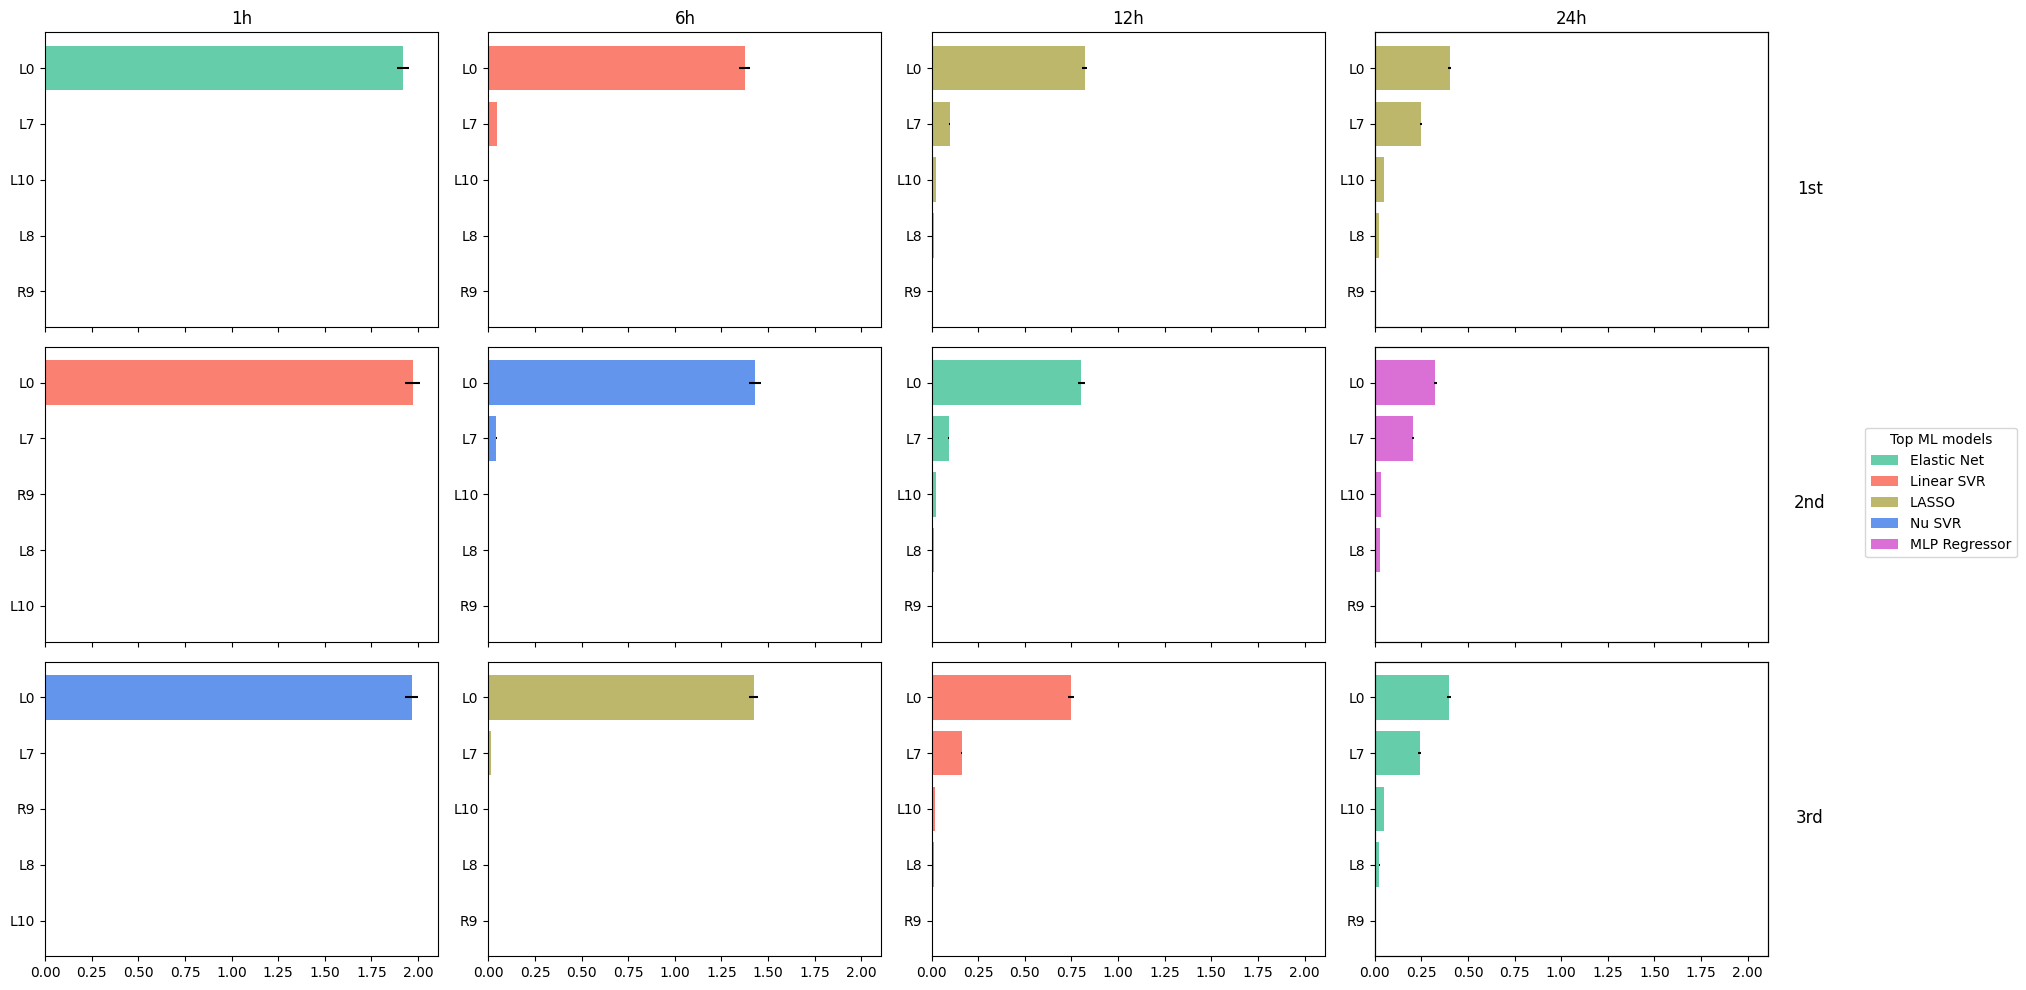

In [29]:
# Plotting permutation importance
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor='mediumaquamarine', label='Elastic Net'),
                   Patch(facecolor='salmon', label='Linear SVR'),
                   Patch(facecolor='darkkhaki', label='LASSO'),
                   Patch(facecolor='cornflowerblue', label='Nu SVR'),
                   Patch(facecolor='orchid', label='MLP Regressor'),
                  ]

fig, axes = plt.subplots(3, 4, sharex='all', figsize=(20,10));
#axes[0,0].invert_yaxis()
plot_permutation_importance(exp21, features=[0,7,8,10,12], ax = axes[0,0], bar_kw={'color': 'mediumaquamarine'})
plot_permutation_importance(exp22, features=[0,7,8,10,12], ax = axes[1,0], bar_kw={'color': 'salmon'})
plot_permutation_importance(exp23, features=[0,7,8,10,12], ax = axes[2,0], bar_kw={'color': 'cornflowerblue'})
plot_permutation_importance(exp24, features=[0,7,8,10,12], ax = axes[0,1], bar_kw={'color': 'salmon'})
plot_permutation_importance(exp25, features=[0,7,8,10,12], ax = axes[1,1], bar_kw={'color': 'cornflowerblue'})
plot_permutation_importance(exp26, features=[0,7,8,10,12], ax = axes[2,1], bar_kw={'color': 'darkkhaki'})
plot_permutation_importance(exp27, features=[0,7,8,10,12], ax = axes[0,2], bar_kw={'color': 'darkkhaki'})
plot_permutation_importance(exp28, features=[0,7,8,10,12], ax = axes[1,2], bar_kw={'color': 'mediumaquamarine'})
plot_permutation_importance(exp29, features=[0,7,8,10,12], ax = axes[2,2], bar_kw={'color': 'salmon'})
plot_permutation_importance(exp30, features=[0,7,8,10,12], ax = axes[0,3], bar_kw={'color': 'darkkhaki'})
plot_permutation_importance(exp31, features=[0,7,8,10,12], ax = axes[1,3], bar_kw={'color': 'orchid'})
plot_permutation_importance(exp32, features=[0,7,8,10,12], ax = axes[2,3], bar_kw={'color': 'mediumaquamarine'})
axes[0,0].set_title("1h")
axes[1,0].set_title(None)
axes[2,0].set_title(None)
axes[0,1].set_title("6h")
axes[1,1].set_title(None)
axes[2,1].set_title(None)
axes[0,2].set_title("12h")
axes[1,2].set_title(None)
axes[2,2].set_title(None)
axes[0,3].set_title("24h")
axes[1,3].set_title(None)
axes[2,3].set_title(None)
axes[0,0].set_xlabel(None)
axes[1,0].set_xlabel(None)
axes[2,0].set_xlabel(None)
axes[0,1].set_xlabel(None)
axes[1,1].set_xlabel(None)
axes[2,1].set_xlabel(None)
axes[0,2].set_xlabel(None)
axes[1,2].set_xlabel(None)
axes[2,2].set_xlabel(None)
axes[0,3].set_xlabel(None)
axes[1,3].set_xlabel(None)
axes[2,3].set_xlabel(None)
axes2 = axes[0,3].twinx()
axes2.set_ylabel('1st', rotation=0, fontsize=12, labelpad=30)
axes2.set_yticks([])
axes3 = axes[1,3].twinx()
axes3.set_ylabel('2nd', rotation=0, fontsize=12, labelpad=30)
axes3.set_yticks([])
axes4 = axes[2,3].twinx()
axes4.set_ylabel('3rd', rotation=0, fontsize=12, labelpad=30)
axes4.set_yticks([])
axes[1,3].legend(handles=legend_elements, bbox_to_anchor=(1.65, .75), title = "Top ML models")
plt.tight_layout()
fig.savefig('Fig5.png')